In [14]:
import tensorflow as tf
import imageio.v3 as imageio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import math

from IPython import display

In [64]:
IMAGE_ORIGINAL_SIZE = 512
IMAGE_TARGET_SIZE = 256
IMAGE_MAX_VAL = 0xFFFF
IMAGE_MIN_VAL = 0x0000

IMAGES_COUNT = 5000

IMAGE_NAME_PREFIX = ""
IMAGE_NAME_POSTFIX = "_h.png"
TRAIN_DATASET_DIR = "./dataset"
OUTPUT_DIR = "./output"

USE_SUBDIVISION_FOR_DATASET = True
NORMALIZE_INPUT_IMAGES = True

BLACK_PIXEL_VALUE_THRESHOLD = IMAGE_MIN_VAL + 5 # pixels below this value will be considered black
BLACK_PIXELS_FACTOR = 0.02 # image will be discarded if the percentage of all pixels below BLACK_PIXEL_VALUE_THRESHOLD is higher than this
BLACK_PIXELS_MAX_COUNT = BLACK_PIXELS_FACTOR * pow(IMAGE_TARGET_SIZE,2)
print(BLACK_PIXELS_MAX_COUNT)

WHITE_PIXEL_VALUE_THRESHOLD = IMAGE_MAX_VAL - 5 # pixels above this value will be considered white
WHITE_PIXELS_FACTOR = 0.02 # image will be discarded if the percentage of all pixels below WHITE_PIXEL_VALUE_THRESHOLD is higher than this
WHITE_PIXELS_MAX_COUNT = WHITE_PIXELS_FACTOR * pow(IMAGE_TARGET_SIZE,2)
print(WHITE_PIXELS_MAX_COUNT)



1310.72
1310.72


# Loading images

In [65]:

approved_count = 0
discarded_count = 0
DIV = np.int32(math.floor(IMAGE_ORIGINAL_SIZE/IMAGE_TARGET_SIZE))
train_images = np.zeros((np.int32(IMAGES_COUNT * DIV * DIV), IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE, 1), 'float16')
print("Starting loading images with subdivision.")

for i in range(1,IMAGES_COUNT + 1):
    image_name = ""
    if i < 10:
       image_name = "000"
    elif i < 100:
        image_name = "00"
    elif i < 1000: 
        image_name = "0"
    
    image_name = f"{IMAGE_NAME_PREFIX}{image_name}{i}{IMAGE_NAME_POSTFIX}"
    image_path = f"{TRAIN_DATASET_DIR}/{image_name}"
    img = Image.open(image_path,formats=["PNG"])
    
    images_arr = []

    if USE_SUBDIVISION_FOR_DATASET:  
        # Subdividing images instead of resizing
        for y in range(DIV):
            for x in range(DIV):
                subdiv_x = img.size[0]/DIV
                subdiv_y = img.size[1]/DIV
            
                left = y * subdiv_y
                right = (y + 1)*subdiv_y
                top = x * subdiv_x
                bottom = (x + 1)*subdiv_x

                subimg = img.crop((left, top, right, bottom))
                subimg.resize((IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE), Image.LANCZOS)
                subimg = np.asarray(subimg)
                if subimg.max() != subimg.min() \
                    and (subimg < BLACK_PIXEL_VALUE_THRESHOLD).sum() < BLACK_PIXELS_MAX_COUNT \
                    and (subimg > WHITE_PIXEL_VALUE_THRESHOLD).sum() < WHITE_PIXELS_MAX_COUNT:
                    images_arr.append(subimg)
                else:
                    discarded_count += 1
    else:
        images_arr.append(np.asarray(img.resize((IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE), Image.LANCZOS)))


    for j in range(len(images_arr)):
        if NORMALIZE_INPUT_IMAGES:
            train_images[approved_count,:,:,0] = np.interp(images_arr[j], (images_arr[j].min(),images_arr[j].max()), (-1, 1))
        else:
            train_images[approved_count,:,:,0] = np.interp(images_arr[j], (IMAGE_MIN_VAL,IMAGE_MAX_VAL), (-1, 1))
        approved_count += 1
    if (i % max(2,(IMAGES_COUNT/100))) == 0 or i == 0:
        display.clear_output(wait=True)
        print(f"Images loaded {i}/{IMAGES_COUNT}, {i*100/IMAGES_COUNT }%")
        print(f"Approved {approved_count}/{approved_count + discarded_count}")
        print(f"Discarded {discarded_count}/{approved_count + discarded_count}")


train_images.resize(np.int32(IMAGES_COUNT * DIV * DIV) - discarded_count, IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE, 1)
print(train_images.shape)


Images loaded 5000/5000, 100.0%
Approved 10474/20000
Discarded 9526/20000
(10474, 256, 256, 1)


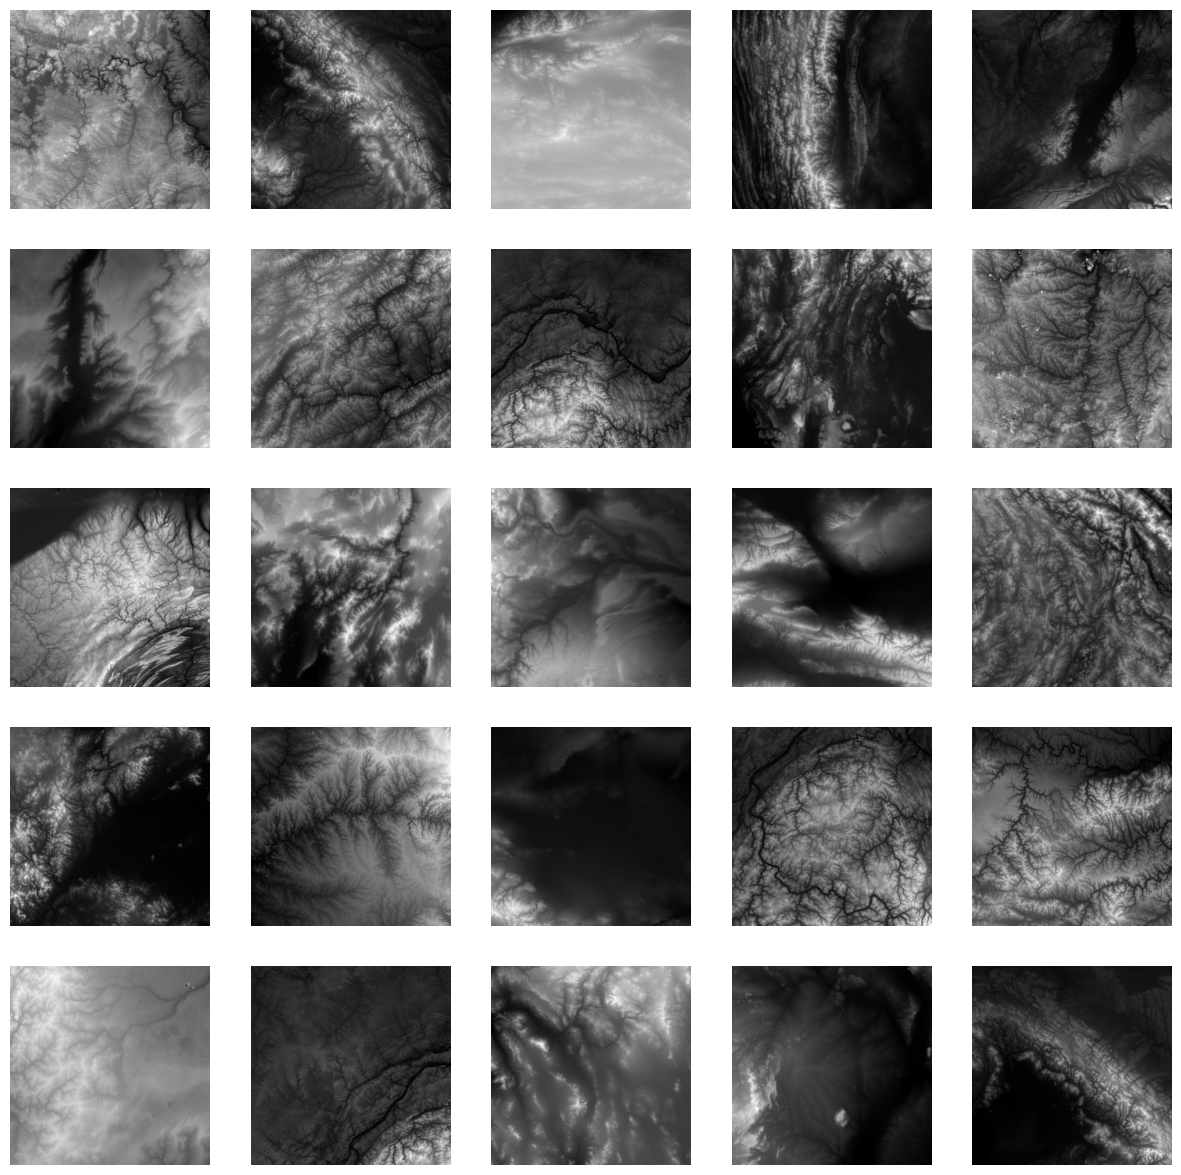

In [84]:
x = np.random.randint(0,train_images.shape[0],25)
plt.figure(figsize=(15,15))

for k in range(5):
    for j in range(5):
        plt.subplot(5,5,k*5+j+1)
        #img = Image.fromarray()
        plt.axis('off')
        plt.imshow(train_images[x[k*5+j],:,:], cmap='gray')
plt.show()

In [67]:
print(train_images[:,:,:].min())
print(train_images[:,:,:].max())
print(train_images.shape)

-1.0
1.0
(10474, 256, 256, 1)


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 50
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#NOTES: More strides seems to give better results
#THIS GIVES GOOD RESULTS AFTER ~300 epochs
def make_generator_model():
    FIRST_LAYER = np.int32((IMAGE_TARGET_SIZE/32))
    model = tf.keras.Sequential()
    model.add(layers.Dense(FIRST_LAYER*FIRST_LAYER*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((FIRST_LAYER, FIRST_LAYER, 256)))
    print(model.output_shape)
    assert model.output_shape == (None, FIRST_LAYER, FIRST_LAYER, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (8, 8), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, FIRST_LAYER*2, FIRST_LAYER*2, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (6, 6), strides=(4, 4), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, FIRST_LAYER*8, FIRST_LAYER*8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, FIRST_LAYER*16, FIRST_LAYER*16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(32, (6, 6), strides=(2, 2), padding='same', use_bias=False))
    #print(model.output_shape)
    #assert model.output_shape == (None, FIRST_LAYER*8, FIRST_LAYER*8, 32)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

(None, 4, 4, 256)
(None, 8, 8, 128)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 128, 128, 1)


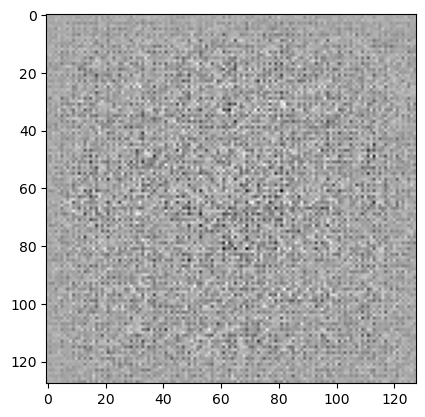

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
#print(generated_image[0,:,:])
plt.imshow(generated_image[0, :, :], cmap='gray')

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00016391]], shape=(1, 1), dtype=float32)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 600
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    filename = OUTPUT_DIR
    filename += '/image_at_epoch_{:04d}'.format(epoch)
    filename += '.png'
    plt.savefig(filename)
    plt.show()


def generate_and_save_one_image(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        img = Image.fromarray(np.array(np.int32(predictions[i, :, :, 0] * 32767 + 32767)))
        filename = OUTPUT_DIR
        filename += '/image_at_epoch_{:04d}'.format(epoch)
        filename += f'_{i}.png'
        img.save(filename)
    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(OUTPUT_DIR, epoch))
    plt.show()


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        if (epoch + 1) % 10 == 0 or epoch == 0:
            display.clear_output(wait=True)
            generate_and_save_one_image(generator,
                                        epoch + 1,
                                        seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {}/{} is {} sec'.format(
            epoch + 1, epochs, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


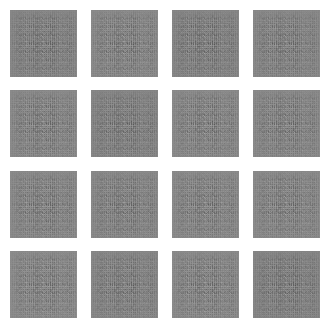

Time for epoch 1/600 is 28.61200213432312 sec


In [ ]:
start = time.time()
train(train_dataset, EPOCHS)
print(f"Training time: {time.time()-start}")

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(f'{OUTPUT_DIR}/' + 'image_at_epoch_{:04d}.png'.format(epoch_no))

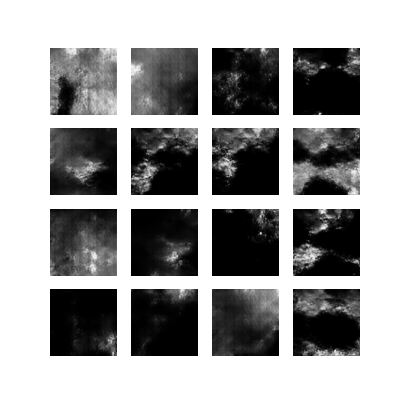

In [24]:
display_image(EPOCHS)